In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage, misc
from PIL import Image
from IPython.display import Image, display
from glob import glob
from matplotlib.image import imread
from keras.models import Sequential, Model, load_model
from keras.utils import plot_model
from keras.layers import *
from keras.callbacks import *
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, adam
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications.inception_v3 import InceptionV3

np.random.seed(3)

Using TensorFlow backend.


In [2]:
# By Augmentation, Accuracy 91.95% -> 93.77%
train_datagen = ImageDataGenerator(rescale=1./255,
    height_shift_range=0.05,\
    width_shift_range=0.05, \
    shear_range = 5, \
    zoom_range = 0.05, \
    rotation_range = 3, \
    horizontal_flip = True, \
    vertical_flip = True, \
    channel_shift_range = 15, \
    samplewise_center = True)
test_datagen = ImageDataGenerator(rescale=1./255, \
    samplewise_center = True)
val_datagen = ImageDataGenerator(rescale=1./255, \
    samplewise_center = True)

batch_size = 32 # 16->64->32
epochs = 200 # 50->100 ->200
root_path = '/home/mywork/kijun_kwon/data_split1'
train_path = root_path +'/train'
val_path = root_path +'/val'
test_path = root_path +'/test'
path_list = [train_path, val_path, test_path]

class_root='/home/mywork/kijun_kwon/data_split1/train'
class_list = [ item for item in os.listdir(class_root) if os.path.isdir(os.path.join(class_root, item)) ]
class_list.sort()
class_weight = {0:1, 1:1, 2:0.3, 3:1, 4:10, 5:10, 6:1}

sizesOfSet = [0, 0, 0] # size of training set, validation set, test set
for p in range(len(path_list)) :
    for i in range(len(class_list)):
        sizesOfSet[p] += (len([name for name in os.listdir(path_list[p] + '/'+ class_list[i]) if os.path.isfile(os.path.join(path_list[p]+ '/'+ class_list[i], name))]))

image_height = 224
image_width = 224
channels = 3

In [3]:
model = InceptionV3(include_top=True, weights = None, input_tensor=None, input_shape=(image_height,image_width,channels), pooling=None, classes=len(class_list))

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        color_mode = "rgb",
        target_size=(image_height, image_width),
        batch_size = batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_path,
        shuffle = False,
        color_mode = "rgb",
        target_size=(image_height, image_width),    
        batch_size=batch_size,
        class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
        val_path,
        color_mode = "rgb",
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 1965 images belonging to 7 classes.
Found 658 images belonging to 7 classes.
Found 655 images belonging to 7 classes.


In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
model_checkpoint = ModelCheckpoint(('./inceptionv3_th5.{epoch:02d}.hdf5'),
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                                         patience=10, verbose=1)

callbacks = [model_checkpoint, reduce_learning_rate]

In [7]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch = sizesOfSet[0] // batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps= sizesOfSet[1] // batch_size,
            callbacks=callbacks,
            class_weight = class_weight)

Epoch 1/200
61/61 [==============================] - 48s 787ms/step - loss: 3.0654 - acc: 0.2004 - val_loss: 13.6587 - val_acc: 0.1375

Epoch 00001: val_loss improved from inf to 13.65867, saving model to ./inceptionv3_th5.01.hdf5
Epoch 2/200
61/61 [==============================] - 30s 484ms/step - loss: 3.5730 - acc: 0.1629 - val_loss: 14.0484 - val_acc: 0.1284

Epoch 00002: val_loss did not improve from 13.65867
Epoch 3/200
61/61 [==============================] - 29s 470ms/step - loss: 2.9415 - acc: 0.1689 - val_loss: 4.2106 - val_acc: 0.1814

Epoch 00003: val_loss improved from 13.65867 to 4.21055, saving model to ./inceptionv3_th5.03.hdf5
Epoch 4/200
61/61 [==============================] - 28s 457ms/step - loss: 3.0945 - acc: 0.1711 - val_loss: 9.1410 - val_acc: 0.1011

Epoch 00004: val_loss did not improve from 4.21055
Epoch 5/200
61/61 [==============================] - 30s 485ms/step - loss: 2.5870 - acc: 0.2310 - val_loss: 6.1197 - val_acc: 0.1990

Epoch 00005: val_loss did 

61/61 [==============================] - 26s 430ms/step - loss: 0.7204 - acc: 0.7150 - val_loss: 0.8131 - val_acc: 0.6918

Epoch 00042: val_loss did not improve from 0.69090
Epoch 43/200
61/61 [==============================] - 26s 434ms/step - loss: 0.7254 - acc: 0.6983 - val_loss: 0.8137 - val_acc: 0.6859

Epoch 00043: val_loss did not improve from 0.69090
Epoch 44/200
61/61 [==============================] - 28s 453ms/step - loss: 0.6493 - acc: 0.7323 - val_loss: 0.5205 - val_acc: 0.7929

Epoch 00044: val_loss improved from 0.69090 to 0.52048, saving model to ./inceptionv3_th5.44.hdf5
Epoch 45/200
61/61 [==============================] - 26s 430ms/step - loss: 0.6785 - acc: 0.7201 - val_loss: 0.6948 - val_acc: 0.7368

Epoch 00045: val_loss did not improve from 0.52048
Epoch 46/200
61/61 [==============================] - 28s 454ms/step - loss: 0.7774 - acc: 0.7116 - val_loss: 1.8329 - val_acc: 0.4254

Epoch 00046: val_loss did not improve from 0.52048
Epoch 47/200
61/61 [===========

61/61 [==============================] - 28s 464ms/step - loss: 0.3033 - acc: 0.8571 - val_loss: 0.3562 - val_acc: 0.8828

Epoch 00083: val_loss did not improve from 0.35293
Epoch 84/200
61/61 [==============================] - 29s 474ms/step - loss: 0.3468 - acc: 0.8445 - val_loss: 0.6842 - val_acc: 0.7817

Epoch 00084: val_loss did not improve from 0.35293
Epoch 85/200
61/61 [==============================] - 31s 504ms/step - loss: 0.3803 - acc: 0.8493 - val_loss: 1.2012 - val_acc: 0.6266

Epoch 00085: val_loss did not improve from 0.35293
Epoch 86/200
61/61 [==============================] - 30s 498ms/step - loss: 0.3682 - acc: 0.8410 - val_loss: 0.6234 - val_acc: 0.7865

Epoch 00086: val_loss did not improve from 0.35293
Epoch 87/200
61/61 [==============================] - 28s 459ms/step - loss: 0.2940 - acc: 0.8776 - val_loss: 0.3645 - val_acc: 0.8636

Epoch 00087: val_loss did not improve from 0.35293
Epoch 88/200
61/61 [==============================] - 31s 515ms/step - loss: 0

61/61 [==============================] - 27s 445ms/step - loss: 0.2018 - acc: 0.9221 - val_loss: 0.2570 - val_acc: 0.9133

Epoch 00124: val_loss did not improve from 0.24559
Epoch 125/200
61/61 [==============================] - 26s 430ms/step - loss: 0.1587 - acc: 0.9178 - val_loss: 0.2776 - val_acc: 0.9246

Epoch 00125: val_loss did not improve from 0.24559
Epoch 126/200
61/61 [==============================] - 27s 437ms/step - loss: 0.1512 - acc: 0.9275 - val_loss: 0.2696 - val_acc: 0.9262

Epoch 00126: val_loss did not improve from 0.24559
Epoch 127/200
61/61 [==============================] - 26s 431ms/step - loss: 0.1483 - acc: 0.9255 - val_loss: 0.2665 - val_acc: 0.9250

Epoch 00127: val_loss did not improve from 0.24559
Epoch 128/200
61/61 [==============================] - 31s 510ms/step - loss: 0.1444 - acc: 0.9276 - val_loss: 0.2689 - val_acc: 0.9310

Epoch 00128: val_loss did not improve from 0.24559
Epoch 129/200
61/61 [==============================] - 27s 441ms/step - lo

61/61 [==============================] - 25s 418ms/step - loss: 0.1157 - acc: 0.9401 - val_loss: 0.2490 - val_acc: 0.9230

Epoch 00166: val_loss did not improve from 0.20479
Epoch 167/200
61/61 [==============================] - 27s 448ms/step - loss: 0.1255 - acc: 0.9376 - val_loss: 0.2577 - val_acc: 0.9246

Epoch 00167: val_loss did not improve from 0.20479
Epoch 168/200
61/61 [==============================] - 26s 420ms/step - loss: 0.1259 - acc: 0.9378 - val_loss: 0.2656 - val_acc: 0.9197

Epoch 00168: val_loss did not improve from 0.20479
Epoch 169/200
61/61 [==============================] - 26s 418ms/step - loss: 0.1537 - acc: 0.9460 - val_loss: 0.2663 - val_acc: 0.9203

Epoch 00169: val_loss did not improve from 0.20479
Epoch 170/200
61/61 [==============================] - 28s 457ms/step - loss: 0.1053 - acc: 0.9513 - val_loss: 0.2471 - val_acc: 0.9230

Epoch 00170: val_loss did not improve from 0.20479
Epoch 171/200
61/61 [==============================] - 25s 409ms/step - lo

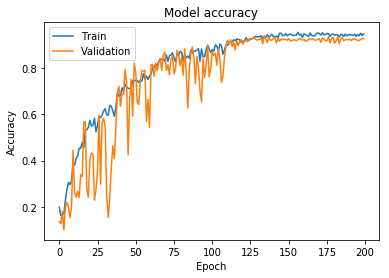

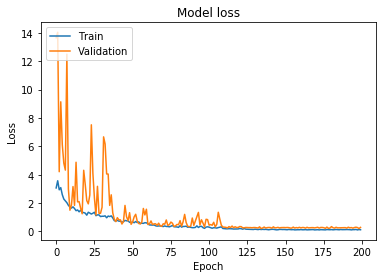

In [8]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
Y_pred = model.predict_generator(test_generator, sizesOfSet[2] // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('\tConfusion Matrix')
conf = confusion_matrix(test_generator.classes, y_pred)
print(conf)
print('\n\t\t\tClassification Report')
report = classification_report(test_generator.classes, y_pred, target_names=class_list)
report_dict = classification_report(test_generator.classes, y_pred, target_names=class_list, output_dict = True)
print(report)
print("\n-- Evaluate --")
scores = model.evaluate_generator(test_generator)
under = 1-report_dict['ok']['precision']
over = 1-report_dict['ok']['recall']
print("%s: %.2f\t%s: %.2f%%\n과검율: %.2f%%\t 미검율: %.2f%%"
      %(model.metrics_names[0], scores[0], model.metrics_names[1], scores[1]*100,
        over*100, under*100))

	Confusion Matrix
[[122   0   0   0   0   4   2]
 [  2  63   0   0   1   0   8]
 [  3   1 218   0   2   1   0]
 [  1   0   0  68   0   0   0]
 [  0   2   1   0  15   0   0]
 [  0   0   0   0   0  89   0]
 [  3  13   1   1   3   1  33]]

			Classification Report
               precision    recall  f1-score   support

         dent       0.93      0.95      0.94       128
discoloration       0.80      0.85      0.82        74
           ok       0.99      0.97      0.98       225
        other       0.99      0.99      0.99        69
      scratch       0.71      0.83      0.77        18
         sink       0.94      1.00      0.97        89
    substance       0.77      0.60      0.67        55

    micro avg       0.92      0.92      0.92       658
    macro avg       0.87      0.88      0.88       658
 weighted avg       0.92      0.92      0.92       658


-- Evaluate --
loss: 0.23	acc: 92.40%
과검율: 3.11%	 미검율: 0.91%


In [10]:
error_truth = list()
error_count = list()
error_pred = list()
count = 0
for i in range(len(y_pred)):
    if i>0 :
        if test_generator.classes[i-1]!=test_generator.classes[i]:
            count = 0
    if(test_generator.classes[i]!=y_pred[i]):
        error_truth += [test_generator.classes[i]]
        error_count += [count]
        error_pred += [y_pred[i]]
    count += 1

In [11]:
underImageList = list()
for i in range(len(class_list)):
    lgc_file = glob(test_path + '/' + class_list[i] + '/*.jpg')
    for j in range(len(error_truth)):
        if i==error_truth[j] :
#             print('Truth: ')
#             print(class_list[error_truth[j]])
#             print('Predicted as: ')
#             print(class_list[error_pred[j]])
#             display(Image(filename=lgc_file[error_count[j]]) )
            if error_pred[j]==2 :
                underImageList.append(lgc_file[error_count[j]])

In [13]:
underImageList

['/home/mywork/kijun_kwon/data_split1/test/scratch/DDMQL27S_20180111142451_12_BOTTOM.jpg',
 '/home/mywork/kijun_kwon/data_split1/test/substance/DDMQK15S_20171203151901_04_BOTTOM.jpg']

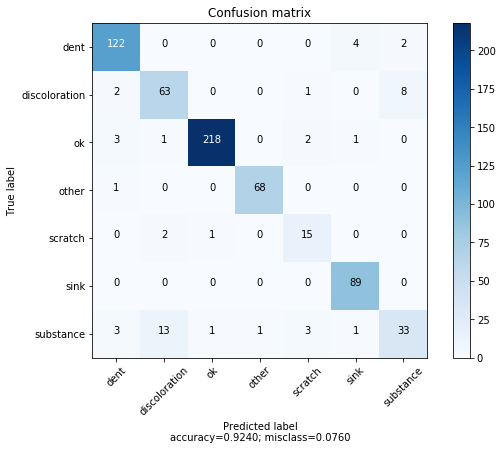

In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
plot_confusion_matrix(conf,
                          class_list,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)